### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# import pgeocode as pg

### Initial load, clean, and merge

In [6]:
df_rechnung_total = pd.read_parquet('data/Rechnungen.parquet')
rechnung_columns = ["Unternehmen", "Artikel_SK", "Auftragsdatum_SK", "Kunde_Verkauf_SK", "Umsatztyp", "Preis Verpackungseinheit", "Menge", "Nettoumsatz", "Productgroup", "Productsubgroup", "Business Area", "Type"]
df_rechnung = df_rechnung_total[rechnung_columns]

df_kunden_total = pd.read_csv('data/Kunden.csv', sep=';', low_memory=False)
kunden_columns = ["Kunde_SK", "Ort", "PLZ-Code", "Branchengruppe", "Vertriebskanalkategorie", "Vertriebskanal"]
df_kunden = df_kunden_total[kunden_columns]
df_kunden = df_kunden.rename(columns={"Kunde_SK": "Kunde_Verkauf_SK"})

df = pd.merge(df_rechnung, df_kunden, on="Kunde_Verkauf_SK")

# Translate to English
df = df.rename(columns={
    "Artikel_SK": "ArticleID",
    "Unternehmen": "Company",
    "Auftragsdatum_SK": "OrderDate",
    "Kunde_Verkauf_SK": "CustomerID",
    "Umsatztyp": "RevenueType",
    "Preis Verpackungseinheit": "PricePackagingUnit",
    "Menge": "Quantity",
    "Nettoumsatz": "NetRevenue",
    "Productgroup": "ProductGroup",
    "Productsubgroup": "ProductSubgroup",
    "Business Area": "BusinessArea",
    "Type": "Type",
    "Ort": "City",
    "Vertriebskanalkategorie": "SalesChannelCategory",
    "Vertriebskanal": "SalesChannel",
    "PLZ-Code": "PostalCode",
    "Branchengruppe": "IndustryGroup"
    }
)

df['CustomerID'] = df['CustomerID'].astype(str)
df['SalesChannel'] = df['SalesChannelCategory'].str.split('_').str[0]
df = df[df['SalesChannel'].isin(['B2B', 'B2C', 'B2B2C'])]

df.to_parquet('Final.parquet')

### Adding States based on Postal Codes (Feature Engineering: Step 1)

In [7]:
nomi = pg.Nominatim('de')
df = pd.read_parquet('Final.parquet')

df['State'] = nomi.query_postal_code(df['PostalCode'].astype(str).to_list()).state_name
df.to_parquet('Final.parquet')

NameError: name 'pg' is not defined

### Initial analysis

['Baden-Württemberg' None 'Bayern' 'Hessen' 'Berlin' 'Rheinland-Pfalz'
 'Nordrhein-Westfalen' 'Niedersachsen' 'Hamburg' 'Sachsen'
 'Schleswig-Holstein' 'Brandenburg' 'Saarland' 'Mecklenburg-Vorpommern'
 'Sachsen-Anhalt' 'Bremen' 'Thüringen']


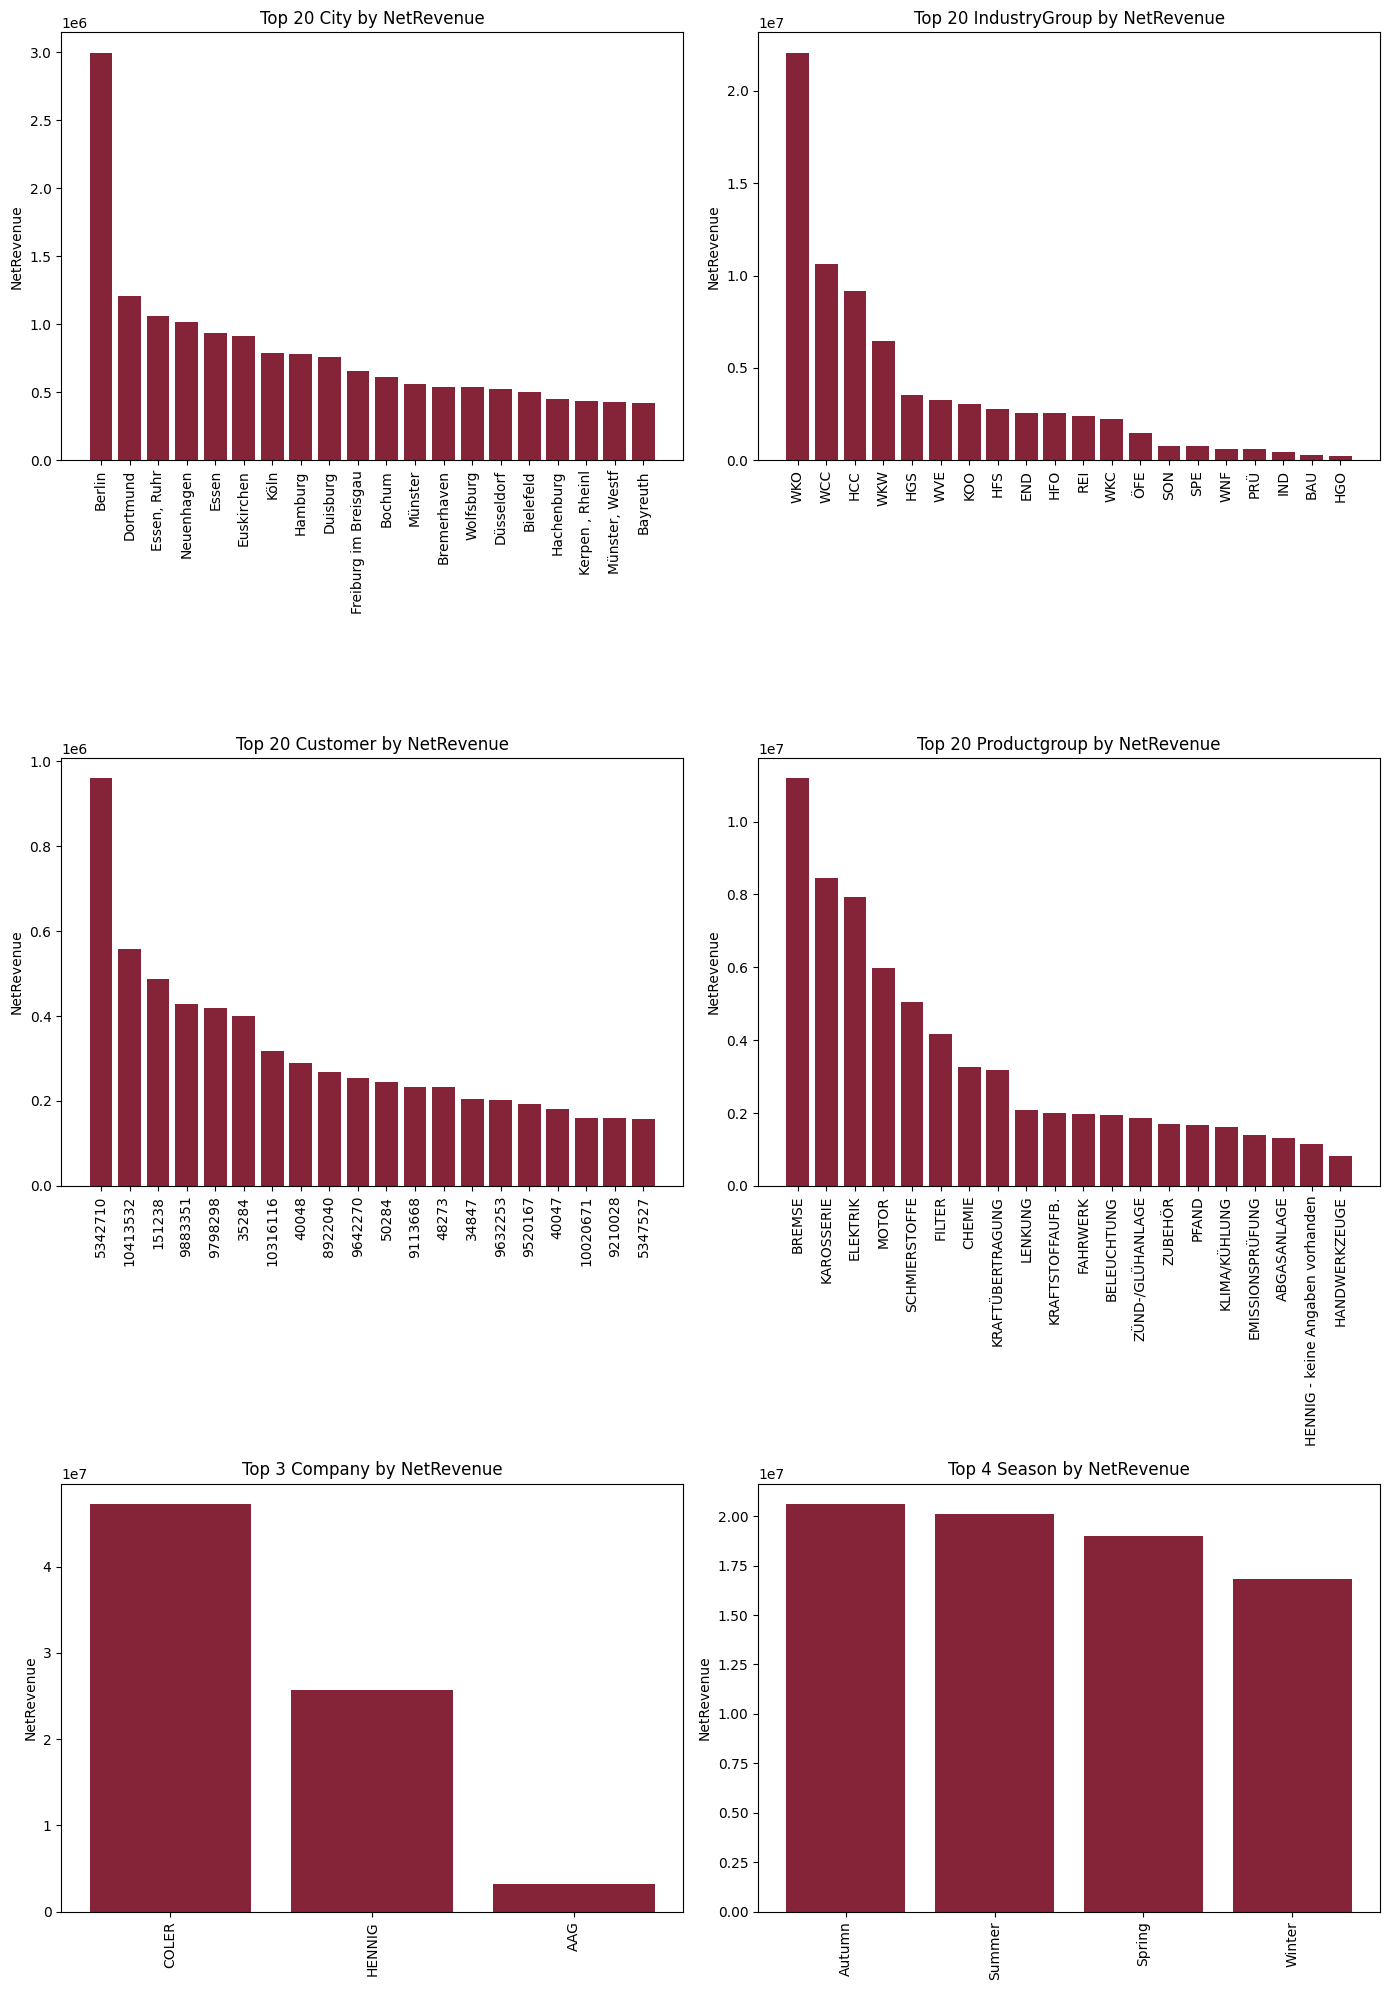

In [9]:
df = pd.read_parquet('data/Final.parquet')
# df = pd.read_parquet('data/Final_03-06-24.parquet') --> This is for Vahap's machine.

# Convert SalesDate_SK to datetime
df['OrderDate'] = pd.to_datetime(df['OrderDate'], format='%Y%m%d')

print(df['State'].unique())

# Add column for season
def season_from_month(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Unknown'
    
df['Season'] = df['OrderDate'].dt.month.apply(season_from_month)

# Only keep rows in 2023
df = df[df['OrderDate'].dt.year == 2023]

def plot_top_n_by_column(data, group_column, value_column, n, title_suffix='', ax=None):
    if ax is None:
        ax = plt.gca()  # Gets the current axis if none is provided
    result = data.groupby(group_column)[value_column].sum().reset_index()
    result = result.sort_values(value_column, ascending=False).head(n)
    ax.bar(result[group_column], result[value_column], color='#852339')
    ax.set_xticks(range(len(result))) # Prevents overlapping labels
    ax.set_xticklabels(result[group_column], rotation=90)
    ax.set_ylabel(value_column)
    ax.set_title(f'Top {n} {title_suffix} by {value_column}')

fig, axs = plt.subplots(3, 2, figsize=(14, 20))

plot_top_n_by_column(df, 'City', 'NetRevenue', 20, title_suffix='City', ax=axs[0, 0])
plot_top_n_by_column(df, 'IndustryGroup', 'NetRevenue', 20, title_suffix='IndustryGroup', ax=axs[0, 1])
plot_top_n_by_column(df, 'CustomerID', 'NetRevenue', 20, title_suffix='Customer', ax=axs[1, 0])
plot_top_n_by_column(df, 'ProductGroup', 'NetRevenue', 20, title_suffix='Productgroup', ax=axs[1, 1])
plot_top_n_by_column(df, 'Company', 'NetRevenue', 3, title_suffix='Company', ax=axs[2, 0])
plot_top_n_by_column(df, 'Season', 'NetRevenue', 4, title_suffix='Season', ax=axs[2, 1])

plt.tight_layout()
plt.show()

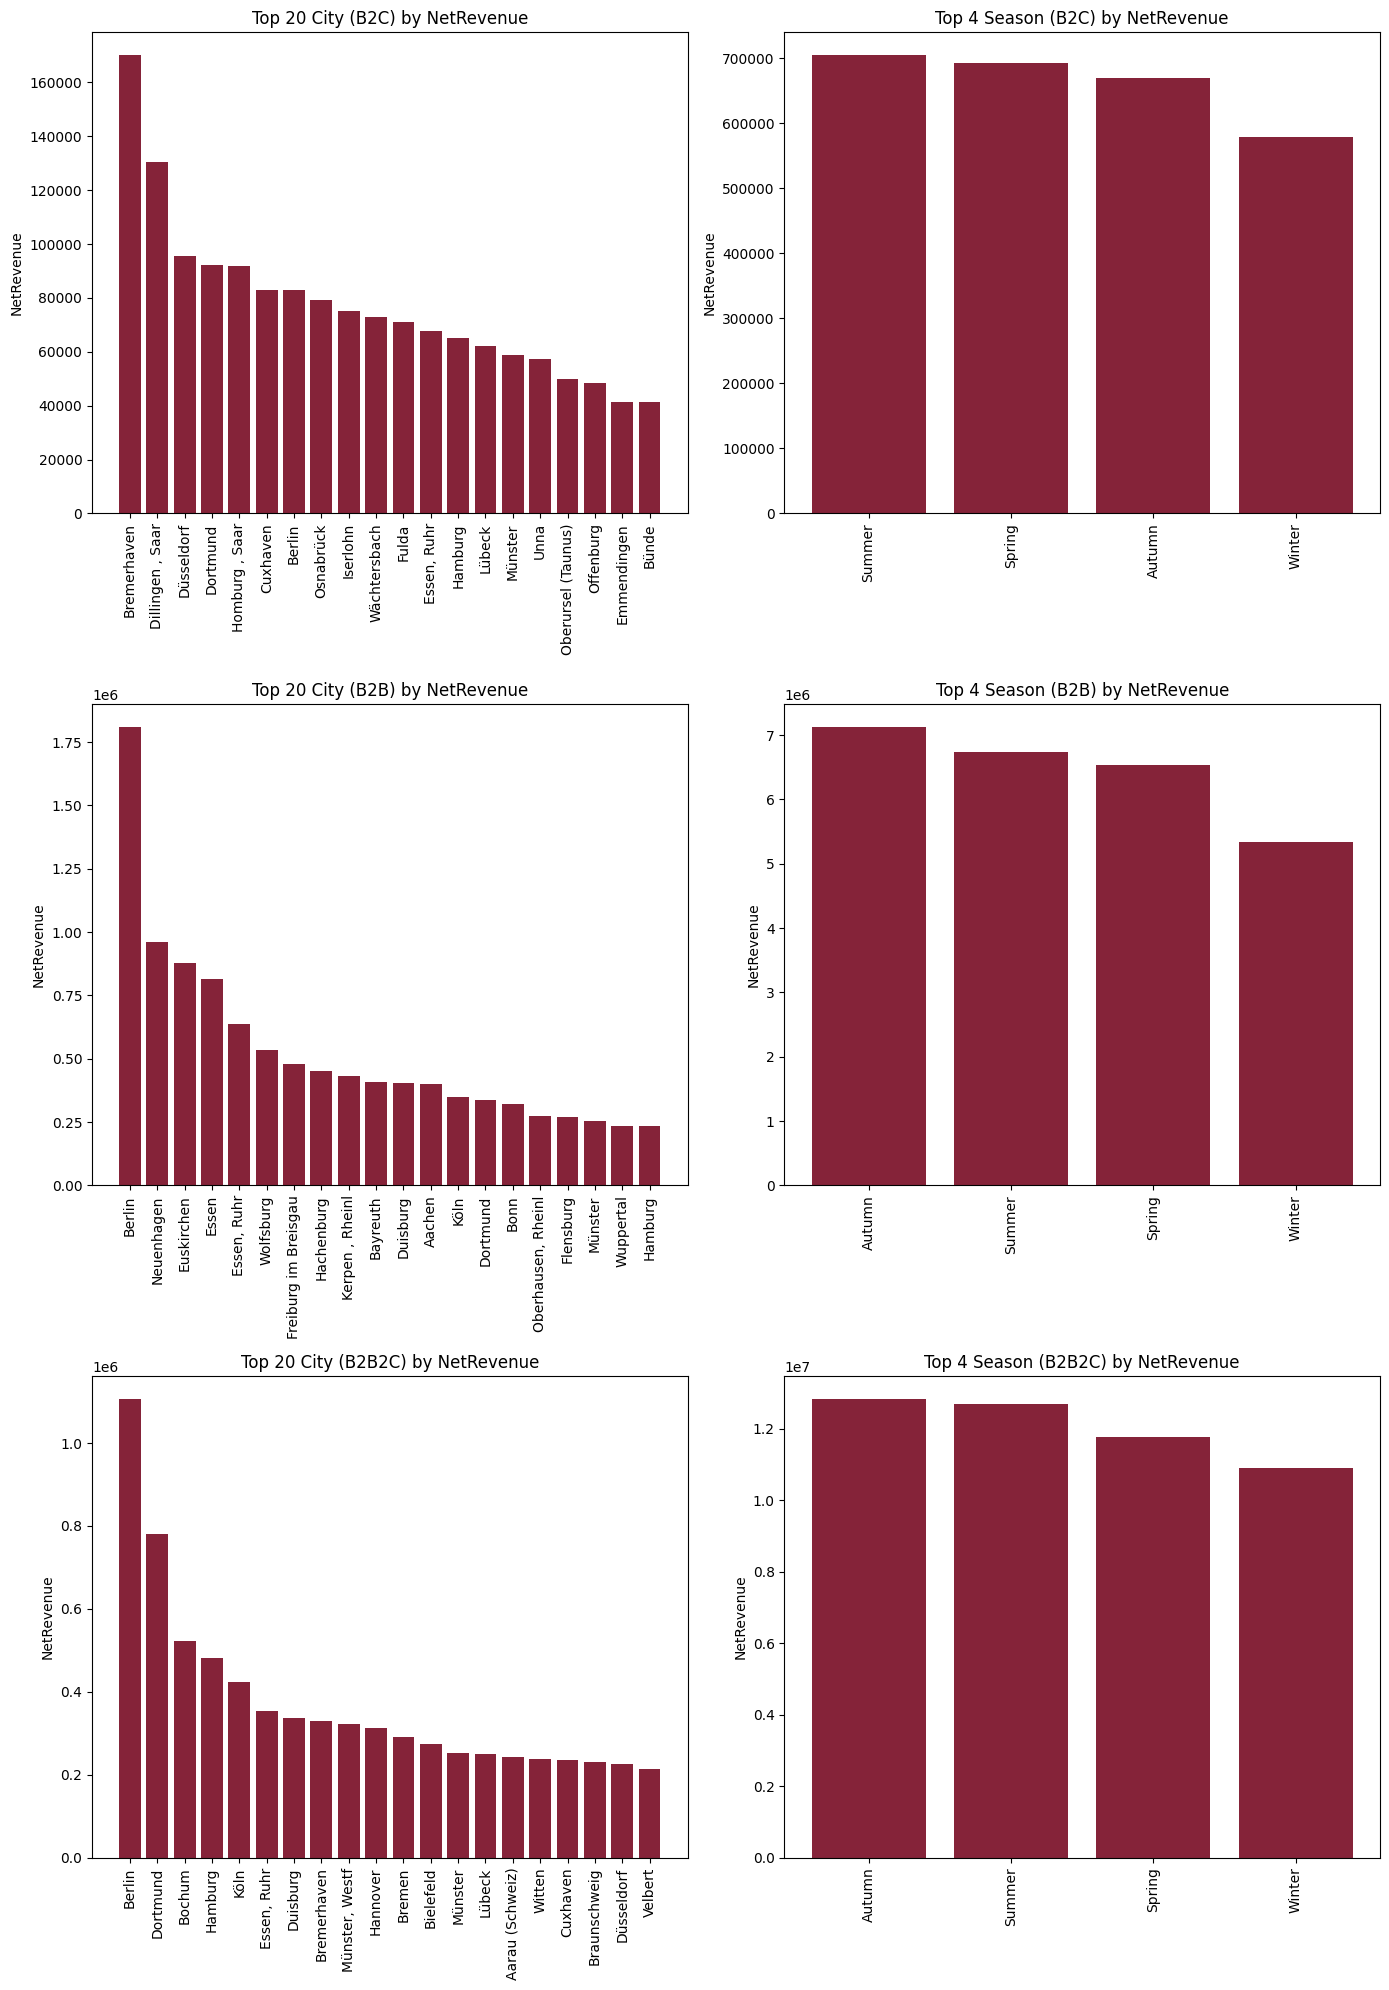

In [10]:
df_b2b = df[df['SalesChannel'] == 'B2B']
df_b2c = df[df['SalesChannel'] == 'B2C']
df_b2b2c = df[df['SalesChannel'] == 'B2B2C']

fig, axs = plt.subplots(3, 2, figsize=(14, 20))

plot_top_n_by_column(df_b2c, 'City', 'NetRevenue', 20, title_suffix='City (B2C)', ax=axs[0, 0])
plot_top_n_by_column(df_b2c, 'Season', 'NetRevenue', 4, title_suffix='Season (B2C)', ax=axs[0, 1])
plot_top_n_by_column(df_b2b, 'City', 'NetRevenue', 20, title_suffix='City (B2B)', ax=axs[1, 0])
plot_top_n_by_column(df_b2b, 'Season', 'NetRevenue', 4, title_suffix='Season (B2B)', ax=axs[1, 1])
plot_top_n_by_column(df_b2b2c, 'City', 'NetRevenue', 20, title_suffix='City (B2B2C)', ax=axs[2, 0])
plot_top_n_by_column(df_b2b2c, 'Season', 'NetRevenue', 4, title_suffix='Season (B2B2C)', ax=axs[2, 1])
plt.tight_layout()
plt.show()

In [8]:
print(df)

         Company  ArticleID  OrderDate CustomerID     RevenueType  \
0            AAG  106155952 2023-02-07     147456  Serviceauftrag   
1            AAG  108629180 2023-02-07     147456  Serviceauftrag   
2            AAG  108629180 2023-04-03     147828  Serviceauftrag   
3            AAG  104537470 2023-02-07     147456  Serviceauftrag   
4            AAG  105814252 2023-01-02     150085        Rechnung   
...          ...        ...        ...        ...             ...   
20082231  HENNIG  112422549 2023-12-21   10245331        Rechnung   
20088379  HENNIG  103035014 2023-11-27    9642270        Rechnung   
20092212  HENNIG  103067758 2023-08-24    5346999        Rechnung   
20096797  HENNIG  113116979 2023-12-01    5339944        Rechnung   
20104140  HENNIG  105917229 2023-12-18    9795305        Rechnung   

          PricePackagingUnit  Quantity  NetRevenue  \
0                   0.248691       1.0    0.248691   
1                   6.413613       1.0    6.413613   
2        

18.765698% of the records are 'FILTER'.
13.605297% of the records are 'BREMSE'.
8.915357% of the records are 'KAROSSERIE'.
8.403069% of the records are 'MOTOR'.
6.650011% of the records are 'ELEKTRIK'.
5.090614% of the records are 'CHEMIE'.
4.071492% of the records are 'SCHMIERSTOFFE'.
3.820467% of the records are 'HENNIG - keine Angaben vorhanden'.
3.667101% of the records are 'LENKUNG'.
3.250313% of the records are 'ZÜND-/GLÜHANLAGE'.
2.879975% of the records are 'WS-BEDARF'.
2.473352% of the records are 'BELEUCHTUNG'.
2.395396% of the records are 'KRAFTÜBERTRAGUNG'.
2.229700% of the records are 'FRACHTEN'.
2.115084% of the records are 'PFAND'.
2.015649% of the records are 'FAHRWERK'.
1.982046% of the records are 'ABGASANLAGE'.
1.861493% of the records are 'KLIMA/KÜHLUNG'.
1.468948% of the records are 'ZUBEHÖR'.
0.918169% of the records are 'KRAFTSTOFFAUFB.'.
0.878500% of the records are 'HANDWERKZEUGE'.
0.543712% of the records are 'REIFEN&RAD'.
0.526931% of the records are 'KATALOG

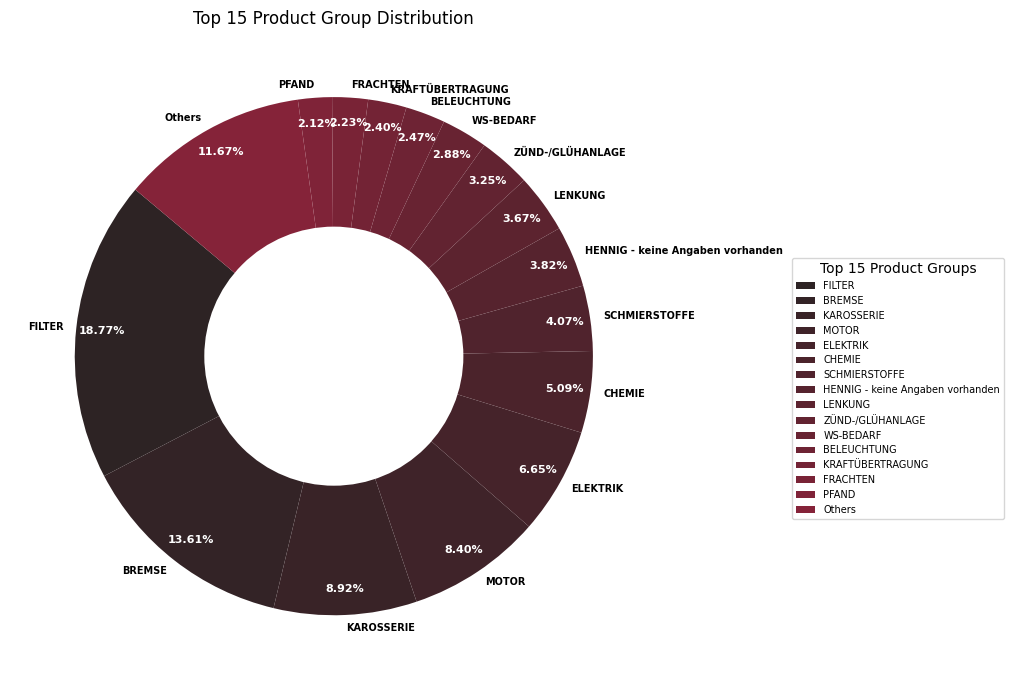

In [11]:
total_records = int(len(df))

# Finding the percentages for every product specifically.
value_counter = df['ProductGroup'].value_counts()
percentages_product = (value_counter/total_records)*100
for value, percentage in percentages_product.items():
    print(f"{percentage:.6f}% of the records are '{value}'.")

# Piechart creation
import seaborn as sns
import matplotlib.pyplot as plot

# Pie Chart for Product Group (shows only top 15 and others)
percentages_product_df = percentages_product.reset_index()
percentages_product_df.columns = ['ProductGroup', 'Percentage']
top_15_product_df = percentages_product_df.head(15)
others_product_percentage = percentages_product_df['Percentage'][15:].sum()
others_product_percentage_df = pd.DataFrame({'ProductGroup': ['Others'], 'Percentage':[others_product_percentage]})
top_15_product_df = pd.concat([top_15_product_df, others_product_percentage_df], ignore_index = True)

# Define the base color
base_color = "#852339"
# Generate a palette based on the base color
colour_palette = sns.dark_palette(base_color, n_colors = len(top_15_product_df))

# Custom function to place percentages in the center
def autopct(pct):
    return f'{pct:.2f}%'

# Plotting the pie chart with improved visualization
plot.figure(figsize=(10, 7))

# Plot pie chart with custom colors
wedges, texts, autotexts = plot.pie(
    top_15_product_df['Percentage'], 
    labels=top_15_product_df['ProductGroup'], 
    autopct=autopct, 
    startangle=140, 
    pctdistance=0.9,      # Position the percentage labels inside the slices
    labeldistance=1.05,   # Position the product group labels outside the slices
    colors=colour_palette # Use the defined color palette
)

# Improve the aesthetics of the texts
for text in texts:
    text.set_fontsize(7)
    text.set_fontweight('bold')

for autotext in autotexts:
    autotext.set_fontsize(8)  # Set the font size of the percentages
    autotext.set_fontweight('bold')
    autotext.set_color('white')

# Draw circle to make it a donut chart
centre_circle = plot.Circle((0, 0), 0.50, fc='white')
fig = plot.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle.
plot.gca().set_aspect('equal')

plot.title('Top 15 Product Group Distribution')
plot.legend(wedges, top_15_product_df['ProductGroup'], title="Top 15 Product Groups", loc="center left", bbox_to_anchor=(1.2, 0, 5, 0.9), fontsize=7)  # Reduce legend font size
plot.tight_layout()
plot.show()

5.792268% of the records are 'Berlin'.
2.164039% of the records are 'Neuenhagen'.
1.569792% of the records are 'Euskirchen'.
1.219558% of the records are 'Duisburg'.
1.215078% of the records are 'Dortmund'.
1.080842% of the records are 'Köln'.
0.968717% of the records are 'Düsseldorf'.
0.931383% of the records are 'Aachen'.
0.904206% of the records are 'Kerpen , Rheinl'.
0.893566% of the records are 'Hamburg'.
0.800095% of the records are 'Essen, Ruhr'.
0.726985% of the records are 'Wuppertal'.
0.711055% of the records are 'Essen'.
0.695227% of the records are 'Wolfsburg'.
0.674375% of the records are 'Bremerhaven'.
0.668425% of the records are 'Bochum'.
0.630995% of the records are 'Koeln'.
0.584559% of the records are 'Freiburg im Breisgau'.
0.577629% of the records are 'Bonn'.
0.553917% of the records are 'Bielefeld'.
0.524691% of the records are 'Bottrop'.
0.515848% of the records are 'Münster'.
0.514555% of the records are 'Gelsenkirchen'.
0.510191% of the records are 'Oberhausen,

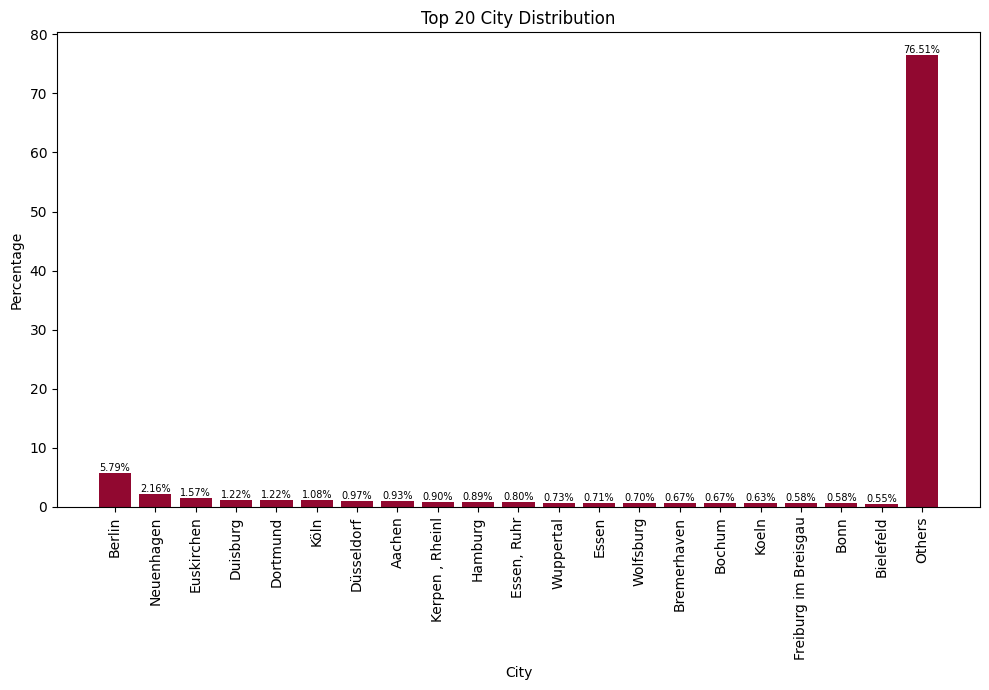

In [12]:
# Finding the percentages for every city specifically.
value_counter_city = df['City'].value_counts()
percentages_city = (value_counter_city/total_records)*100
for value_city, percentage_city in percentages_city.items():
    print(f"{percentage_city:.6f}% of the records are '{value_city}'.")

# Bar Chart for Every City (shows only top 30 and others)
percentages_city_df = percentages_city.reset_index()
percentages_city_df.columns = ['City', 'Percentage']
top_20_city_df = percentages_city_df.head(20)
others_city_percentage = percentages_city_df['Percentage'][20:].sum()
others_city_df = pd.DataFrame({'City': ['Others'], 'Percentage':[others_city_percentage]})
top_20_city_df = pd.concat([top_20_city_df, others_city_df], ignore_index = True)

# Custom function to place percentages in the center
def autopct(pct):
    return f'{pct:.2f}%'

# Plotting the bar chart
plot.figure(figsize=(10, 7))

# Plot bar chart
bars = plot.bar(
    top_20_city_df['City'], 
    top_20_city_df['Percentage'], 
    color= (145/255, 8/255, 48/255)
)

# Add percentages on top of the bars
for bar in bars:
    yval = bar.get_height()
    plot.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}%', ha='center', va='bottom', fontsize=7)

# Set axis labels and title
plot.xlabel('City')
plot.ylabel('Percentage')
plot.title('Top 20 City Distribution')

plot.xticks(rotation=90)  # Rotate x-axis labels for better readability

plot.tight_layout()
plot.show()

42.220513% of the records are 'Nordrhein-Westfalen'.
13.333461% of the records are 'Niedersachsen'.
11.424416% of the records are 'Baden-Württemberg'.
5.786481% of the records are 'Berlin'.
5.739943% of the records are 'Rheinland-Pfalz'.
5.730528% of the records are 'Hessen'.
4.452974% of the records are 'Brandenburg'.
3.493611% of the records are 'Schleswig-Holstein'.
2.693619% of the records are 'Saarland'.
1.008699% of the records are 'Bremen'.
0.848600% of the records are 'Hamburg'.
0.762713% of the records are 'Bayern'.
0.571400% of the records are 'Thüringen'.
0.512825% of the records are 'Sachsen-Anhalt'.
0.257642% of the records are 'Sachsen'.
0.190945% of the records are 'Mecklenburg-Vorpommern'.


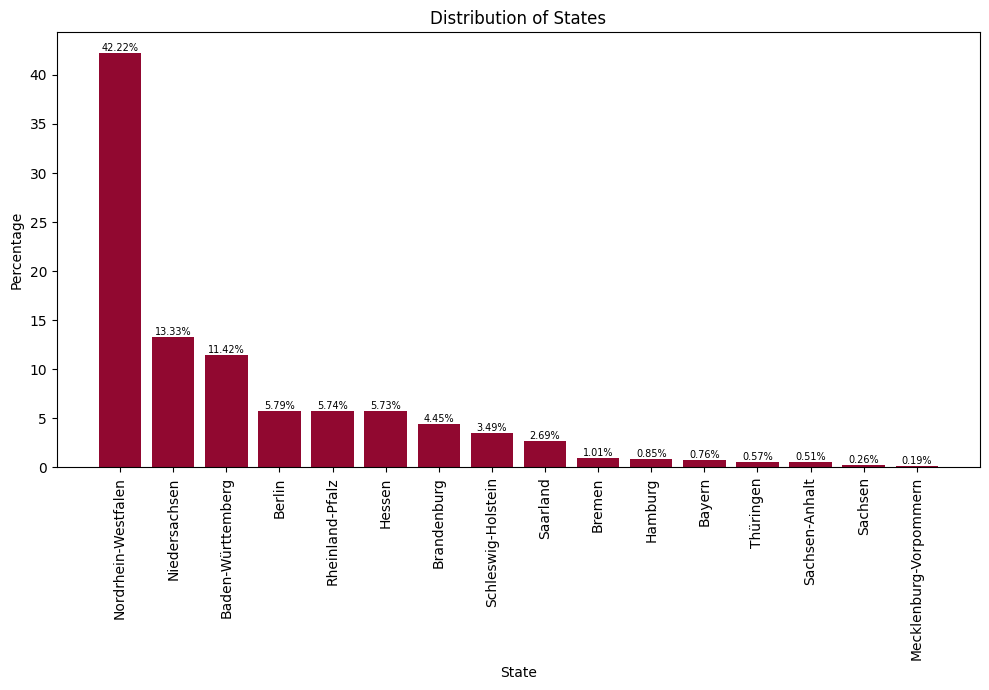

In [13]:
# Finding the percentages for every city specifically.
value_counter_state = df['State'].value_counts()
percentages_state = (value_counter_state/total_records)*100
for value_state, percentage_state in percentages_state.items():
    print(f"{percentage_state:.6f}% of the records are '{value_state}'.")

# Bar Chart for Every City (shows only top 30 and others)
percentages_state_df = percentages_state.reset_index()
percentages_state_df.columns = ['State', 'Percentage']

# Custom function to place percentages in the center
def autopct(pct):
    return f'{pct:.2f}%'

# Plotting the bar chart
plot.figure(figsize=(10, 7))

# Plot bar chart
bars = plot.bar(
    percentages_state_df['State'], 
    percentages_state_df['Percentage'], 
    color= (145/255, 8/255, 48/255)
)

# Add percentages on top of the bars
for bar in bars:
    yval = bar.get_height()
    plot.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}%', ha='center', va='bottom', fontsize=7)

# Set axis labels and title
plot.xlabel('State')
plot.ylabel('Percentage')
plot.title('Distribution of States')

plot.xticks(rotation=90)  # Rotate x-axis labels for better readability

plot.tight_layout()
plot.show()

49.173940% of the records are 'HENNIG'.
45.387117% of the records are 'COLER'.
5.039263% of the records are 'AAG'.
0.333331% of the records are 'BUSCH'.
0.066349% of the records are 'AAS'.


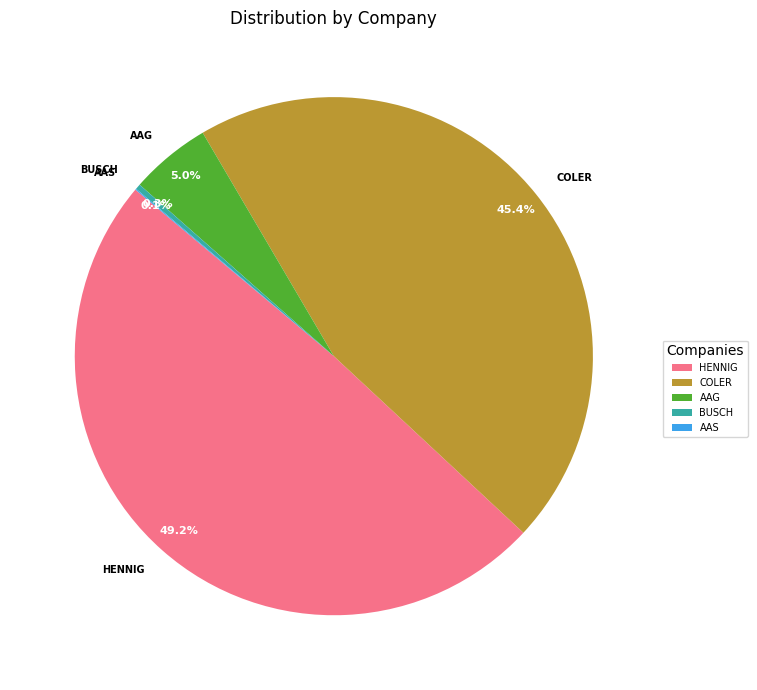

In [12]:
# Finding the percentages for every company specifically.
value_counter_company = df['Company'].value_counts()
percentages_company = (value_counter_company/total_records)*100
for value_company, percentage_company in percentages_company.items():
    print(f"{percentage_company:.6f}% of the records are '{value_company}'.")

# Pie for each company
percentages_company_df = percentages_company.reset_index()
percentages_company_df.columns = ['Company', 'Percentage']

# Define a color palette using seaborn
colour_palette_company  = sns.color_palette("husl")
# Plotting the pie chart
plot.figure(figsize=(10, 7))

# Plot pie chart
wedges, texts, autotexts = plot.pie(
    percentages_company, 
    labels=percentages_company.index, 
    autopct='%1.1f%%', 
    startangle=140,
    pctdistance=0.9,               # Position the percentage labels inside the slices
    labeldistance=1.1,            # Position the product group labels outside the slices
    colors=colour_palette_company, # Use the defined color palette
    textprops=dict(color="black", fontsize=10, fontweight = 'bold')  # Set text color to white for better visibility
)

# Improve the aesthetics of the texts
for text in texts:
    text.set_fontsize(7)
    text.set_fontweight('bold')
    autotext.set_color('black')


# Set properties of the percentages on the pie chart
for autotext in autotexts:
    autotext.set_fontsize(8)
    autotext.set_fontweight('bold')
    autotext.set_color('white')

# Equal aspect ratio ensures that pie is drawn as a circle.
plot.gca().set_aspect('equal')

plot.title('Distribution by Company')
plot.legend(wedges, percentages_company_df['Company'], title="Companies", loc="center left", bbox_to_anchor=(1, 0, 5, 0.9), fontsize=7)  # Reduce legend font size
plot.tight_layout()
plot.show()
